In [346]:
# ---- FEITO POR HENRIQUE PEGORARI PARA LEEGA ----


# Abrindo uma loja de produtos importados abaixo
import pandas as pds
import matplotlib.pyplot as mpl
import seaborn as sea
import scikitplot as skplt
import numpy as np

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from scipy import stats

data_path = "/breastcancer.csv" 
marvada = pds.read_csv(data_path)
marvada['diagnosis'].replace('B', int(0),inplace=True)
marvada['diagnosis'].replace('M', int(1),inplace=True)

# necessidade nenhuma, mas fiz isso pra passar o tempo enquanto pensava no restante do trabalho
if "M" or "B" not in marvada.diagnosis:
  print("Conversão realizada com sucesso")

# Convert to a DataFrame and render.
# pds.DataFrame.from_records(rows)

Conversão realizada com sucesso


In [316]:
sea.set_style("darkgrid")

In [347]:
# data_path = "/breastcancer.csv" 
# marvada = pds.read_csv(data_path)

# Retorna uma cópia do objeto, porém corrigida, sem o erro na última coluna.
# "inplace = false" apenas retorna uma cópia
marvada.drop('Unnamed: 32', axis=1, inplace=True)

In [349]:
# Aqui identifico outliers no dataset, mas ainda não tive a oportunidade de aprender a filtrar isso para que
# possamos ter um 'data mining' melhor e agregar mais valor ao trabalho.
# Porém, gostaria de trazer mesmo assim apenas por conhecimento.
df = pds.DataFrame(np.random.randn(100, 3))
df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

,0,1,2
0,-0.130688,-0.155674,0.467662
1,-1.177755,0.513202,-0.364793
2,-0.240269,-0.822900,-1.100260
3,0.402095,-0.386919,1.452201
4,0.836810,1.667274,0.213527
...,...,...,...
95,0.311909,-0.582426,0.179550
96,1.612268,1.843522,1.460061
97,1.751046,0.061333,-0.645615
98,0.131373,-0.092896,-0.219770


In [333]:
# Retorna as dimensões do dataframe
print("DIMENSÕES DO DATAFRAME:")
print("Linhas:\t\t{}".format(marvada.shape[0]))
print("Colunas:\t{}".format(marvada.shape[1]))


DIMENSÕES DO DATAFRAME:
Linhas:		569
Colunas:	32


In [334]:
# Resumo estatístico das variáveis numéricas (a coluna database é string, ou text pro Excel)
# Subi o dataset de novo e agora está em binary. B = 0 | M = 1
marvada.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [335]:
# ESTÃO TODOS AQUI? - Checando missing values no dataset
marvada.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [336]:
corr = marvada.corr().round(2)
corr

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,1.00,0.04,0.07,0.10,0.07,0.10,-0.01,0.00,0.05,0.04,-0.02,-0.05,0.14,-0.01,0.14,0.18,0.10,0.03,0.06,0.08,-0.02,0.03,0.08,0.06,0.08,0.11,0.01,-0.00,0.02,0.04,-0.04,-0.03
diagnosis,0.04,1.00,0.73,0.42,0.74,0.71,0.36,0.60,0.70,0.78,0.33,-0.01,0.57,-0.01,0.56,0.55,-0.07,0.29,0.25,0.41,-0.01,0.08,0.78,0.46,0.78,0.73,0.42,0.59,0.66,0.79,0.42,0.32
radius_mean,0.07,0.73,1.00,0.32,1.00,0.99,0.17,0.51,0.68,0.82,0.15,-0.31,0.68,-0.10,0.67,0.74,-0.22,0.21,0.19,0.38,-0.10,-0.04,0.97,0.30,0.97,0.94,0.12,0.41,0.53,0.74,0.16,0.01
texture_mean,0.10,0.42,0.32,1.00,0.33,0.32,-0.02,0.24,0.30,0.29,0.07,-0.08,0.28,0.39,0.28,0.26,0.01,0.19,0.14,0.16,0.01,0.05,0.35,0.91,0.36,0.34,0.08,0.28,0.30,0.30,0.11,0.12
perimeter_mean,0.07,0.74,1.00,0.33,1.00,0.99,0.21,0.56,0.72,0.85,0.18,-0.26,0.69,-0.09,0.69,0.74,-0.20,0.25,0.23,0.41,-0.08,-0.01,0.97,0.30,0.97,0.94,0.15,0.46,0.56,0.77,0.19,0.05
area_mean,0.10,0.71,0.99,0.32,0.99,1.00,0.18,0.50,0.69,0.82,0.15,-0.28,0.73,-0.07,0.73,0.80,-0.17,0.21,0.21,0.37,-0.07,-0.02,0.96,0.29,0.96,0.96,0.12,0.39,0.51,0.72,0.14,0.00
smoothness_mean,-0.01,0.36,0.17,-0.02,0.21,0.18,1.00,0.66,0.52,0.55,0.56,0.58,0.30,0.07,0.30,0.25,0.33,0.32,0.25,0.38,0.20,0.28,0.21,0.04,0.24,0.21,0.81,0.47,0.43,0.50,0.39,0.50
compactness_mean,0.00,0.60,0.51,0.24,0.56,0.50,0.66,1.00,0.88,0.83,0.60,0.57,0.50,0.05,0.55,0.46,0.14,0.74,0.57,0.64,0.23,0.51,0.54,0.25,0.59,0.51,0.57,0.87,0.82,0.82,0.51,0.69
concavity_mean,0.05,0.70,0.68,0.30,0.72,0.69,0.52,0.88,1.00,0.92,0.50,0.34,0.63,0.08,0.66,0.62,0.10,0.67,0.69,0.68,0.18,0.45,0.69,0.30,0.73,0.68,0.45,0.75,0.88,0.86,0.41,0.51
concave points_mean,0.04,0.78,0.82,0.29,0.85,0.82,0.55,0.83,0.92,1.00,0.46,0.17,0.70,0.02,0.71,0.69,0.03,0.49,0.44,0.62,0.10,0.26,0.83,0.29,0.86,0.81,0.45,0.67,0.75,0.91,0.38,0.37


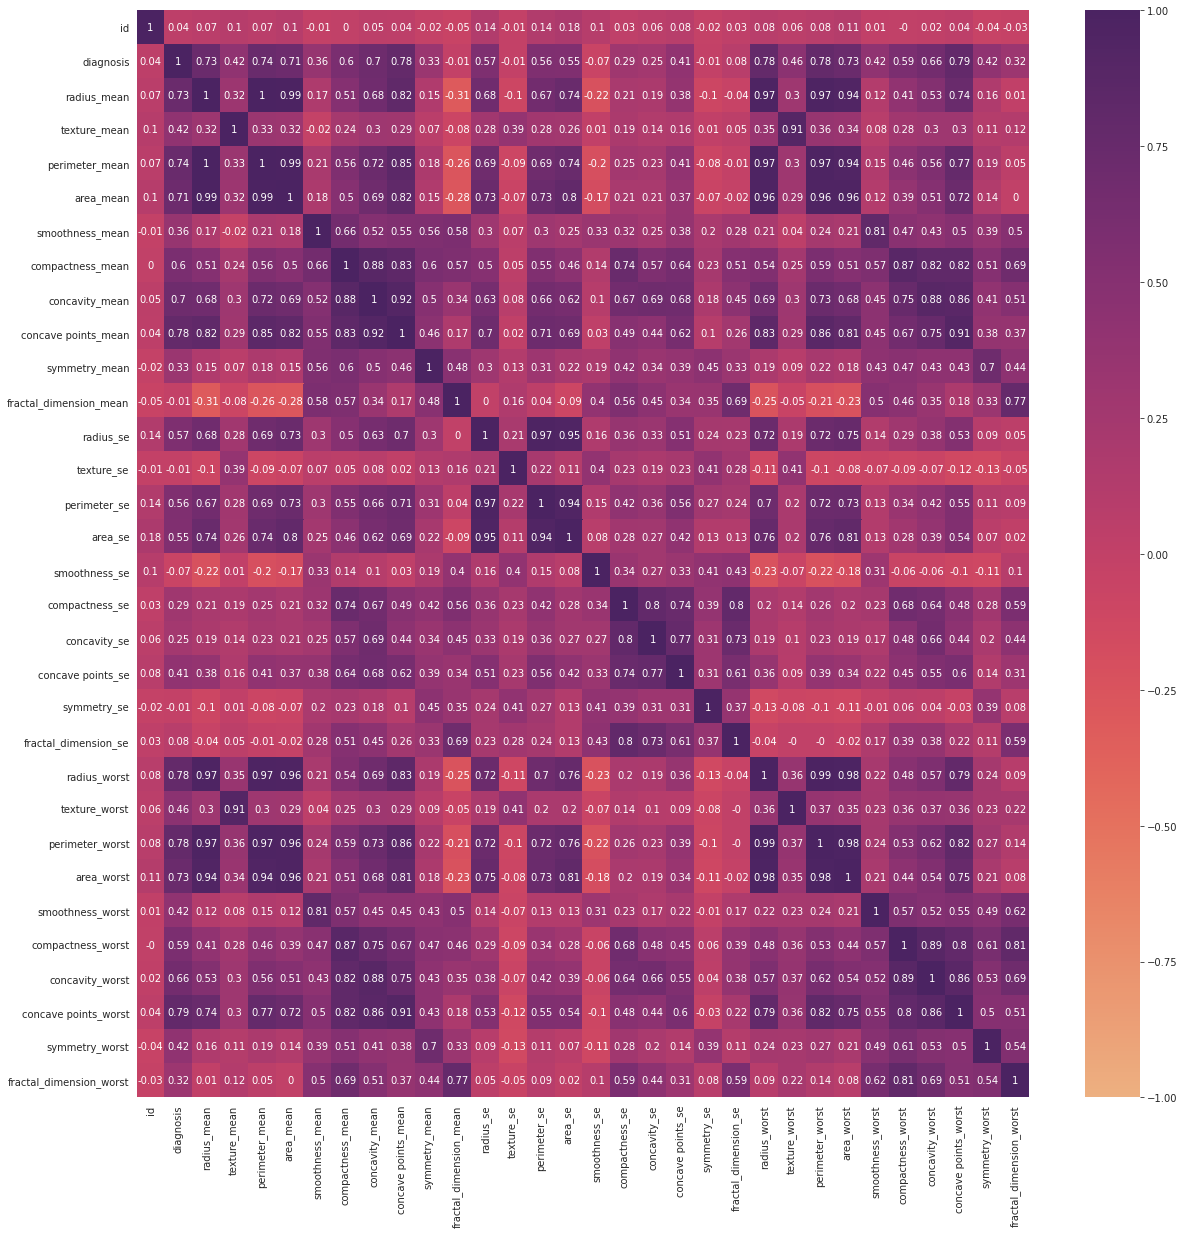

In [337]:
f, ax = mpl.subplots(figsize=(20, 20))
sea.heatmap(corr,annot = True,vmin=-1, vmax=1,center=0,robust=bool,cmap="flare")

0    357
1    212
Name: diagnosis, dtype: int64

Câncers benignos representam aprox. 62.7417% do dataset.
Um pouco desbalanceado, não? Precisamos melhorar isso!

Proporção: 1.68 : 1.0


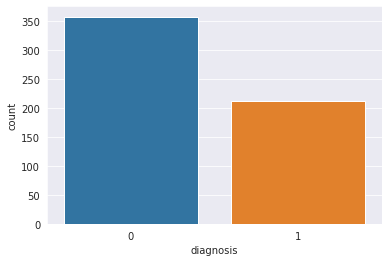

In [338]:
# Conferir balanceamento das classes
print(marvada.diagnosis.value_counts())
print("\nCâncers benignos representam aprox. {:.4f}% do dataset.\nUm pouco desbalanceado, não? Precisamos melhorar isso!\n".format((marvada[marvada.diagnosis == 0].shape[0] / marvada.shape[0]) * 100))

# Plotar gráfico de barras para as Classes
sea.countplot(x='diagnosis', data=marvada);
marvada_count = marvada.diagnosis.value_counts()
print('Proporção:', round(marvada_count[0] / marvada_count[1], 2), ': 1.0')

In [339]:
labels = marvada.columns[2:]

X = marvada[labels]
y = marvada['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Acurácia: %.2f%%" % (accuracy * 100.0))

Acurácia: 95.61%


In [340]:
# Contaremos as classificações
count_class_0, count_class_1 = marvada.diagnosis.value_counts()

# Dividiremos o dataframe por classificação
mar_vada_0 = marvada[marvada['diagnosis'] == 0]
mar_vada_1 = marvada[marvada['diagnosis'] == 1]

E após o random under-sampling aplicado, os casos de câncer benigno sofreram 
uma reduçao para se adequar ao balance correspondente dos cânceres malígnos
1    212
0    212
Name: diagnosis, dtype: int64
Proporção: 1.0 : 1.0


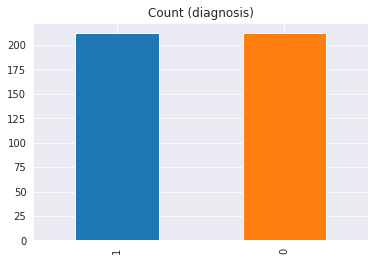

In [341]:
# Deixaremos tudo igual por under-sampling
mar_vada_0_under = mar_vada_0.sample(count_class_1)
marvada_under = pds.concat([mar_vada_0_under, mar_vada_1], axis=0)

print('E após o random under-sampling aplicado, os casos de câncer benigno sofreram \numa reduçao para se adequar ao balance correspondente dos cânceres malígnos')
print(marvada_under.diagnosis.value_counts())
marvada_count = marvada_under.diagnosis.value_counts()
print('Proporção:', round(marvada_count[0] / marvada_count[1], 2), ': 1.0')

marvada_under.diagnosis.value_counts().plot(kind='bar', title='Count (diagnosis)',color = ['#1F77B4', '#FF7F0E']);

In [342]:
labels = marvada.columns[2:]

X = marvada_under[labels]
y = marvada_under['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Acurácia: %.2f%%" % (accuracy * 100.0))

Acurácia: 95.29%
